Training Accuracy: 0.99
Testing Accuracy: 0.87
real Testing Accuracy: 0.44


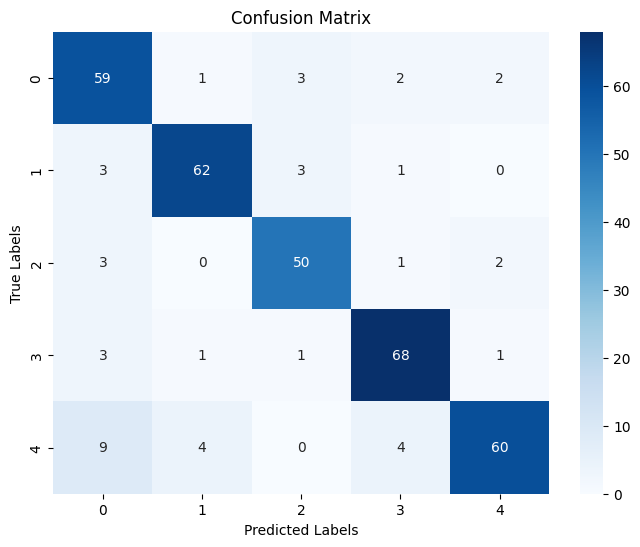

False Negative Rate for Class 0: 0.12
False Negative Rate for Class 1: 0.10
False Negative Rate for Class 2: 0.11
False Negative Rate for Class 3: 0.08
False Negative Rate for Class 4: 0.22

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82        67
           1       0.91      0.90      0.91        69
           2       0.88      0.89      0.88        56
           3       0.89      0.92      0.91        74
           4       0.92      0.78      0.85        77

    accuracy                           0.87       343
   macro avg       0.87      0.87      0.87       343
weighted avg       0.88      0.87      0.87       343



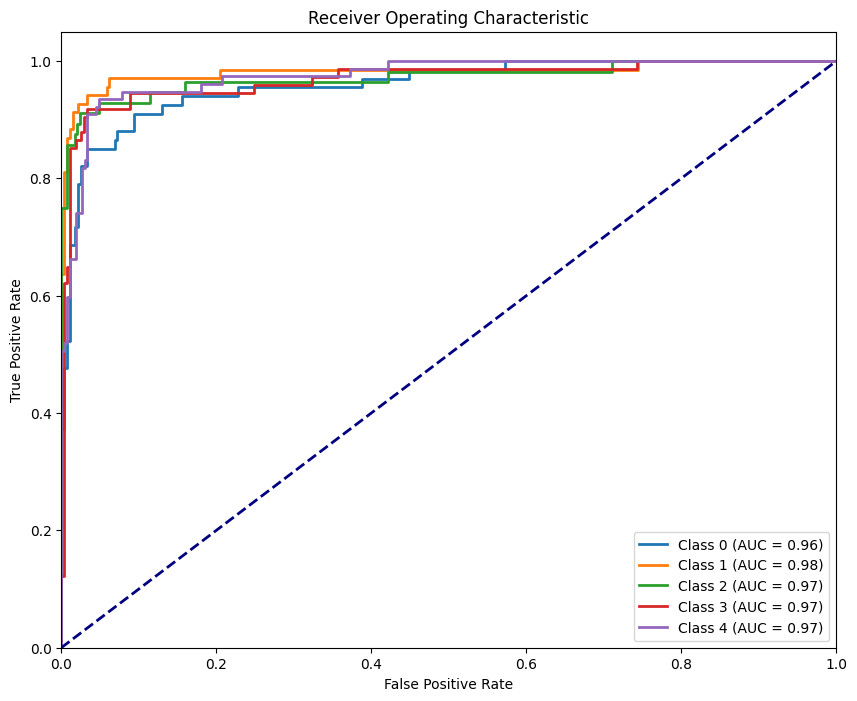

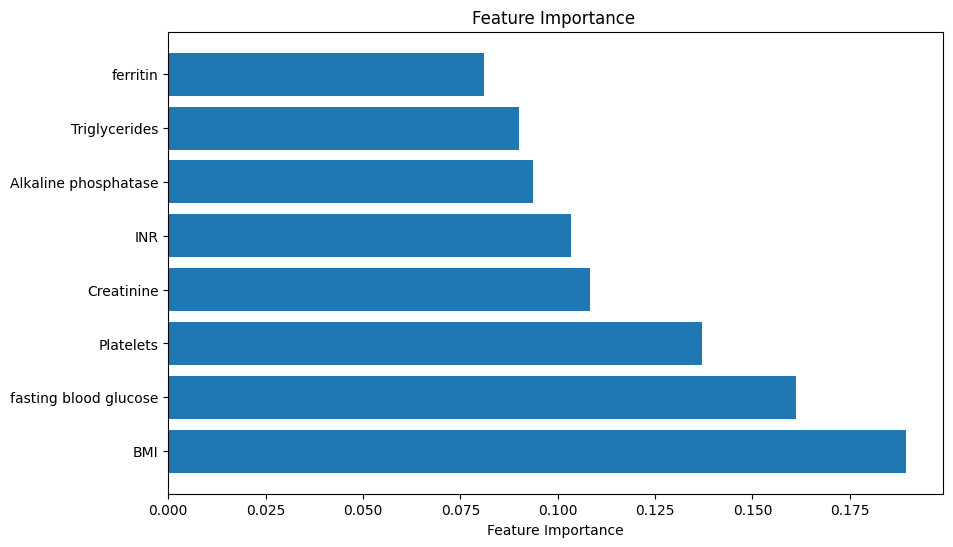

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load training dataset
data = pd.read_excel('/content/7features_f.xlsx')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load external test dataset
test_data_from_file = pd.read_excel('/content/test_7features_f.xlsx')
test_data_from_file.fillna(test_data_from_file.mean(numeric_only=True), inplace=True)


# Splitting features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the data into training and internal testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_test_temp, test_data_from_file.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_test_temp, test_data_from_file['steato score']], axis=0)


# Hyperparameter tuning for RandomForestClassifier with regularization to prevent overfitting
param = {
    'n_estimators': [50, 75],  # Number of trees in the forest
    'max_depth': [3, 5, 7, 10],      # Maximum depth of each tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]    # Minimum number of samples required to be at a leaf node
}

# Model initialization
model_rf = RandomForestClassifier(**param, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model_rf, param_grid=param, cv=5)
grid_search.fit(X_train, y_train)

# Best Model selected
model_rf = grid_search.best_estimator_

train_acc = model_rf.score(X_train, y_train)
test_acc = model_rf.score(X_test_combined, y_test_combined)
real_test_acc = model_rf.score(test_data_from_file.drop('steato score', axis=1),test_data_from_file['steato score'])

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")
print(f"real Testing Accuracy: {real_test_acc:.2f}")

# Evaluation on combined test data
y_test_pred_combined_rf = model_rf.predict(X_test_combined)
y_test_prob_combined_rf = model_rf.predict_proba(X_test_combined)

# Confusion Matrix
def plot_confusion_matrix_rf_with_fnr(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and display False Negative Rate for each class
    fnr_per_class = []
    for i in range(len(classes)):
        fn = cm[i].sum() - cm[i, i]  # False Negatives for class i
        tp = cm[i, i]  # True Positives for class i
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fnr_per_class.append(fnr)
        print(f"False Negative Rate for Class {classes[i]}: {fnr:.2f}")

# Confusion Matrix
cm_combined_rf = confusion_matrix(y_test_combined, y_test_pred_combined_rf)
plot_confusion_matrix_rf_with_fnr(cm_combined_rf, np.unique(y_test_combined))


# Classification Report
report_rf = classification_report(y_test_combined, y_test_pred_combined_rf, target_names=np.unique(y_test_combined).astype(str))
print("\nClassification Report:\n", report_rf)

# ROC Curve
plt.figure(figsize=(10, 8))
for i, cls in enumerate(model_rf.classes_):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), y_test_prob_combined_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_rf, X_test_combined, y_test_combined, n_repeats=10, random_state=42)
importance_scores = perm_importance.importances_mean
sorted_idx_perm = np.argsort(importance_scores)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx_perm], importance_scores[sorted_idx_perm])
plt.xlabel('Feature Importance')
plt.title('Feature Importance ')
plt.show()


Top Features for Class 0 based on predict_proba:
Triglycerides: 0.0015
ALT: 0.0015
Creatinine: 0.0009
TIBC: 0.0000
ferritin: -0.0003
INR: -0.0003
Diabetes: -0.0003
LDL-C: -0.0006
Gender: -0.0009
Albumin: -0.0015
Total bilirubin: -0.0015
AST/ALT: -0.0017
AST: -0.0020
White blood cell: -0.0020
Hemoglobin: -0.0020
Age: -0.0023
fasting blood glucose: -0.0035
Vitamin D: -0.0044
Cholesterol: -0.0047
Platelets: -0.0067
Alkaline phosphatase: -0.0070
BMI: -0.0117


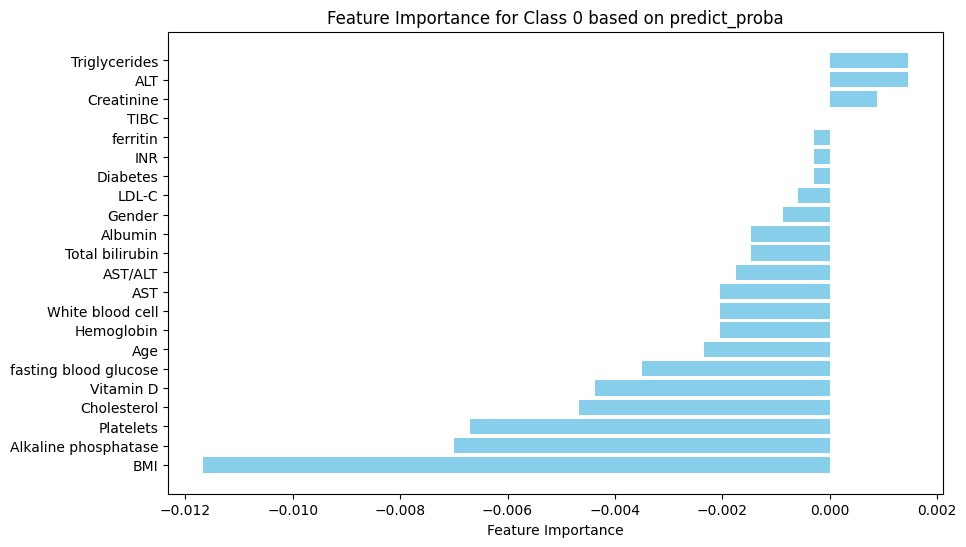


Top Features for Class 1 based on predict_proba:
fasting blood glucose: 0.0134
Triglycerides: 0.0070
Creatinine: 0.0064
Albumin: 0.0050
INR: 0.0032
Hemoglobin: 0.0026
LDL-C: 0.0017
ALT: 0.0017
Diabetes: 0.0015
BMI: 0.0006
TIBC: 0.0000
White blood cell: -0.0003
AST/ALT: -0.0003
AST: -0.0006
Total bilirubin: -0.0006
Gender: -0.0009
ferritin: -0.0012
Cholesterol: -0.0020
Age: -0.0026
Vitamin D: -0.0035
Platelets: -0.0055
Alkaline phosphatase: -0.0061


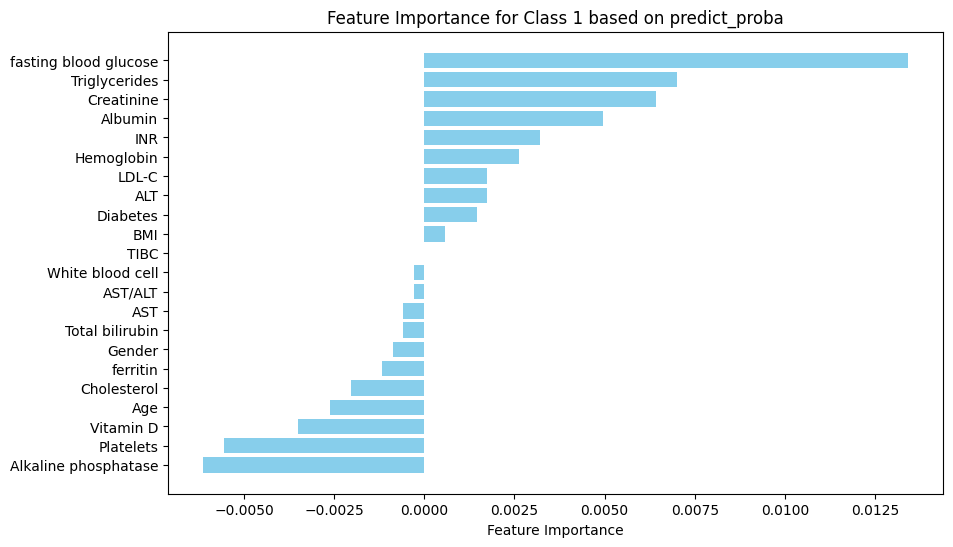


Top Features for Class 2 based on predict_proba:
fasting blood glucose: 0.0125
Triglycerides: 0.0061
Creatinine: 0.0050
INR: 0.0012
Diabetes: 0.0012
Hemoglobin: 0.0000
TIBC: 0.0000
ferritin: -0.0003
LDL-C: -0.0003
Total bilirubin: -0.0006
Albumin: -0.0009
Gender: -0.0009
ALT: -0.0017
AST: -0.0023
White blood cell: -0.0026
Vitamin D: -0.0029
Cholesterol: -0.0032
BMI: -0.0032
AST/ALT: -0.0038
Age: -0.0047
Alkaline phosphatase: -0.0058
Platelets: -0.0076


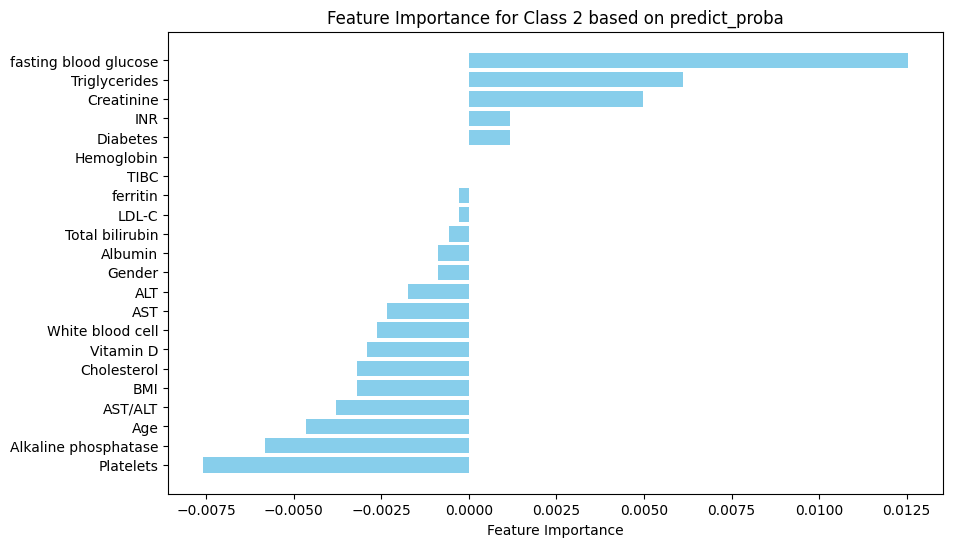


Top Features for Class 3 based on predict_proba:
fasting blood glucose: 0.0122
Triglycerides: 0.0041
INR: 0.0035
ALT: 0.0017
Creatinine: 0.0015
Diabetes: 0.0009
Hemoglobin: 0.0009
TIBC: 0.0000
Total bilirubin: -0.0006
White blood cell: -0.0006
Gender: -0.0009
AST: -0.0009
LDL-C: -0.0009
BMI: -0.0009
ferritin: -0.0020
Age: -0.0029
AST/ALT: -0.0029
Cholesterol: -0.0041
Vitamin D: -0.0047
Alkaline phosphatase: -0.0058
Albumin: -0.0076
Platelets: -0.0079


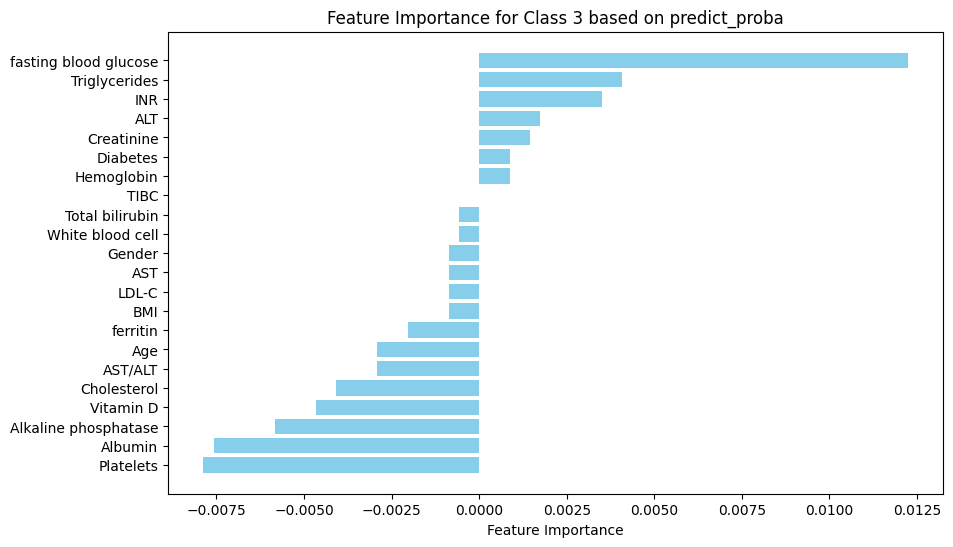


Top Features for Class 4 based on predict_proba:
BMI: 0.0178
fasting blood glucose: 0.0169
Triglycerides: 0.0093
Hemoglobin: 0.0067
Creatinine: 0.0058
AST/ALT: 0.0052
White blood cell: 0.0038
ALT: 0.0032
Albumin: 0.0029
Cholesterol: 0.0029
Age: 0.0020
Diabetes: 0.0015
LDL-C: 0.0012
AST: 0.0012
INR: 0.0006
Total bilirubin: 0.0000
TIBC: 0.0000
Gender: 0.0000
Alkaline phosphatase: -0.0003
Vitamin D: -0.0006
ferritin: -0.0009
Platelets: -0.0023


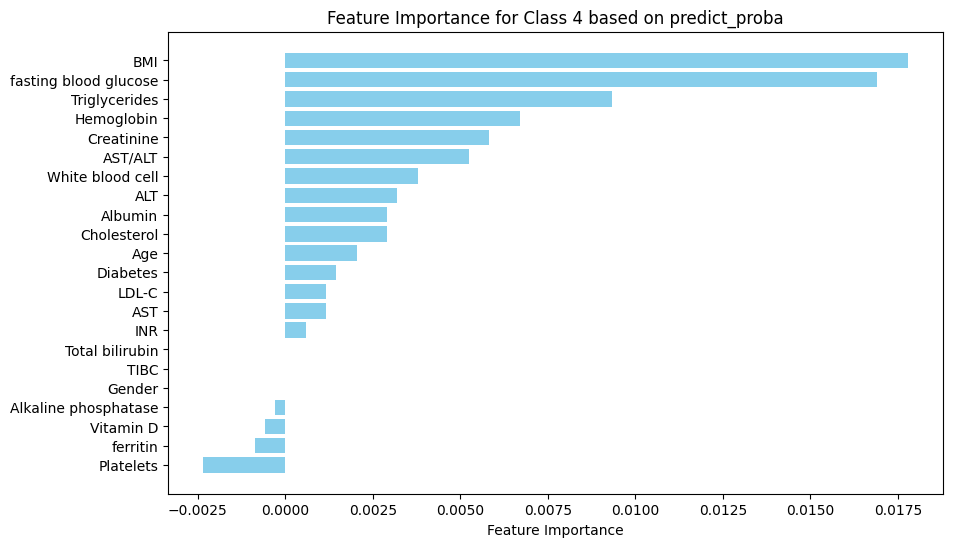

In [ ]:
from sklearn.inspection import permutation_importance
# Feature Importance for each class separately using predict_proba
feature_importances_per_class_proba_rf = {}

# Loop over each class in the model
for class_index, cls in enumerate(model_rf.classes_):
    # Binary target for the current class
    y_binary = (y_test_combined == cls).astype(int)

    # Get predicted probabilities for the current class
    y_pred_proba = model_rf.predict_proba(X_test_combined)[:, class_index]

    # Calculate feature importance based on predict_proba
    result = permutation_importance(model_rf, X_test_combined, y_binary,
                                   scoring='accuracy', n_repeats=10, random_state=42)

    importance_scores = result.importances_mean
    sorted_idx = np.argsort(importance_scores)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_scores = importance_scores[sorted_idx]

    # Print important features for the class
    print(f"\nTop Features for Class {cls} based on predict_proba:")
    for feature, score in zip(sorted_features, sorted_scores):
        print(f"{feature}: {score:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for Class {cls} based on predict_proba')
    plt.show()
